# Data Preprocessing & Visualization


This cell loads the dataset, performs initial data cleaning by dropping irrelevant columns, converts data types, and extracts 'Year' and 'Month' from the 'Updated' column. It also groups rare product categories, preprocesses text and categorical features using TF-IDF and OneHotEncoder, and balances the target variable 'Type' using SMOTE. Finally, it generates several visualizations to explore the data distribution and relationships.

(10000, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Bug ID      10000 non-null  int64 
 1   Type        10000 non-null  object
 2   Summary     10000 non-null  object
 3   Product     10000 non-null  object
 4   Component   10000 non-null  object
 5   Assignee    10000 non-null  object
 6   Status      10000 non-null  object
 7   Resolution  10000 non-null  object
 8   Updated     10000 non-null  object
dtypes: int64(1), object(8)
memory usage: 703.3+ KB
None
             Bug ID
count  1.000000e+04
mean   1.327829e+06
std    5.834898e+05
min    1.772000e+03
25%    9.502318e+05
50%    1.634381e+06
75%    1.764864e+06
max    1.949890e+06
Index(['Bug ID', 'Type', 'Summary', 'Product', 'Component', 'Assignee',
       'Status', 'Resolution', 'Updated'],
      dtype='object')
    Bug ID         Type                                            S

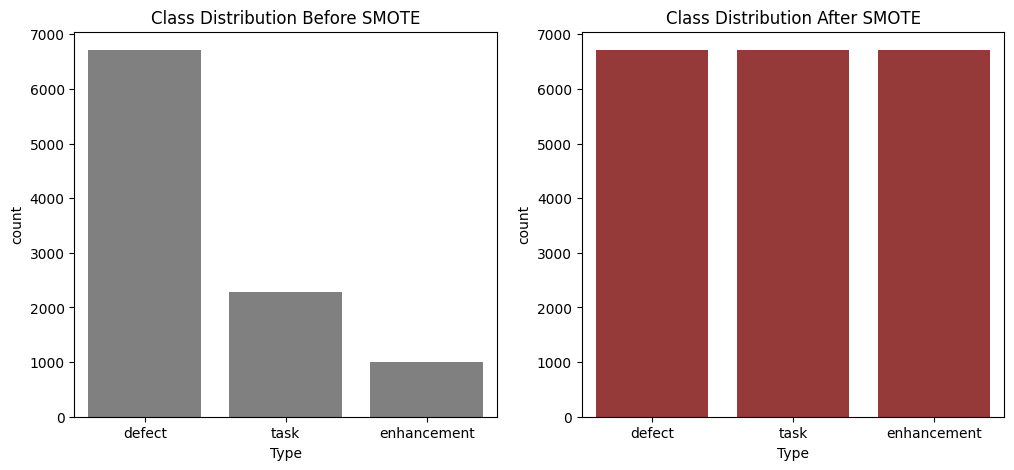

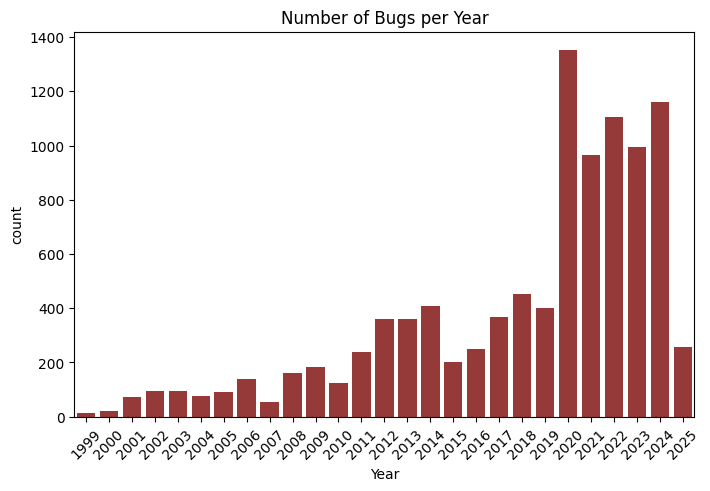

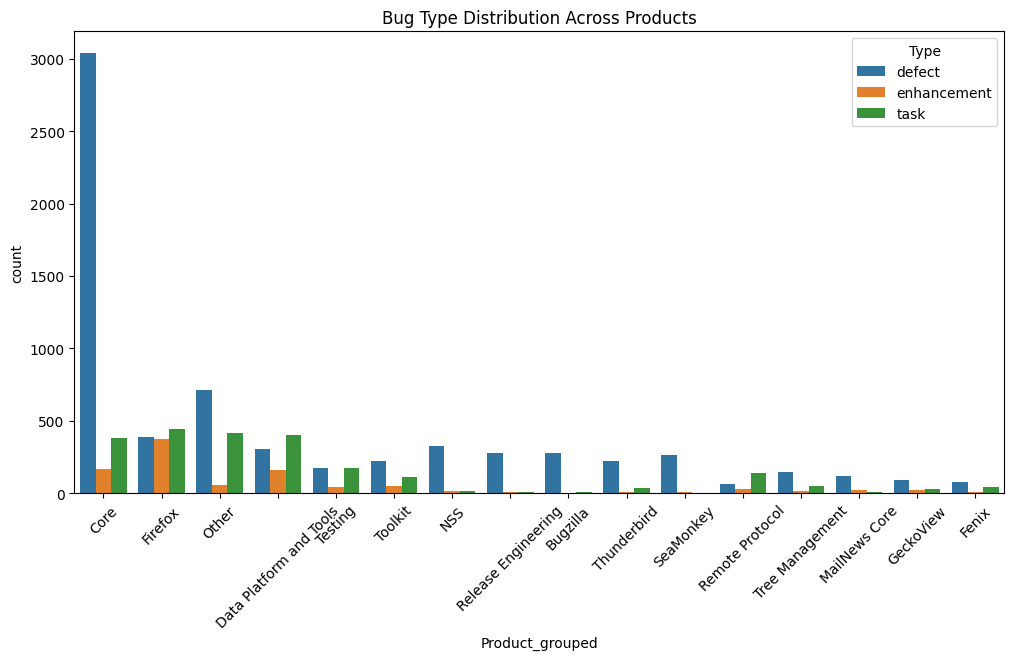

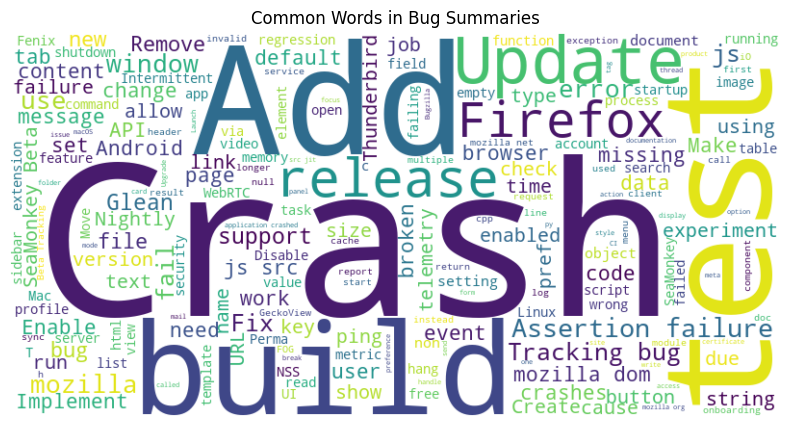

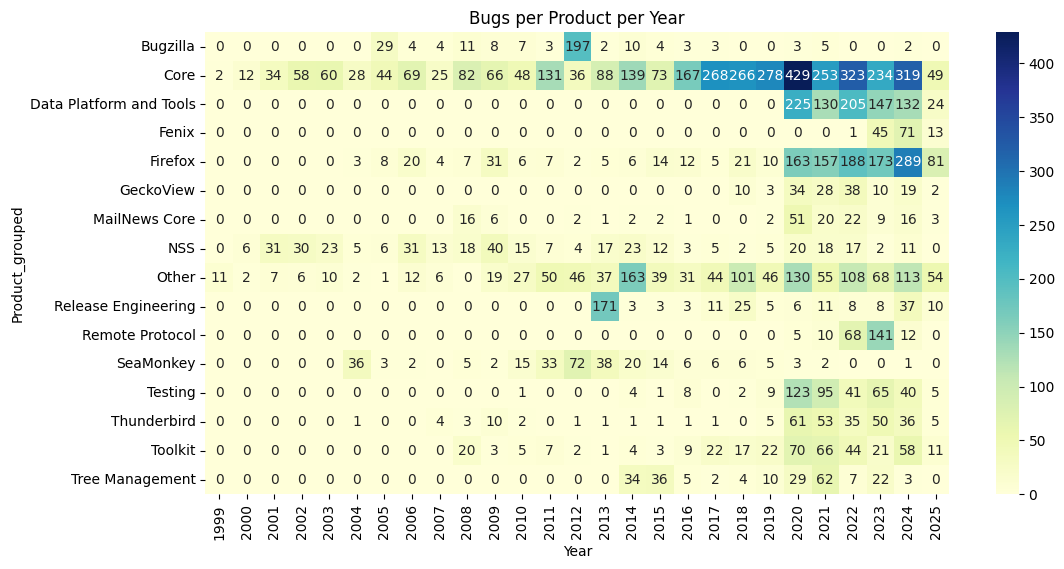

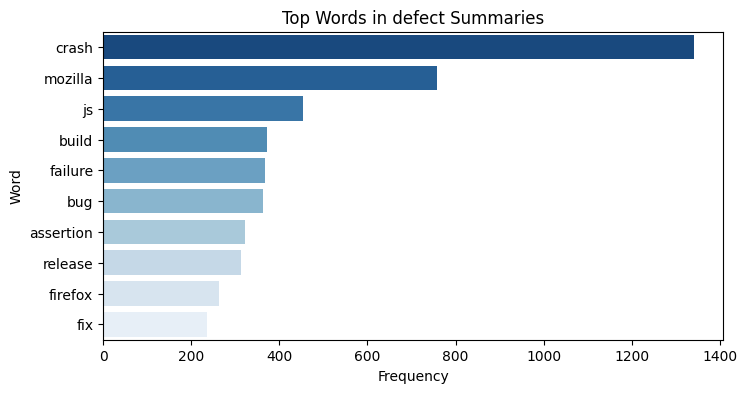

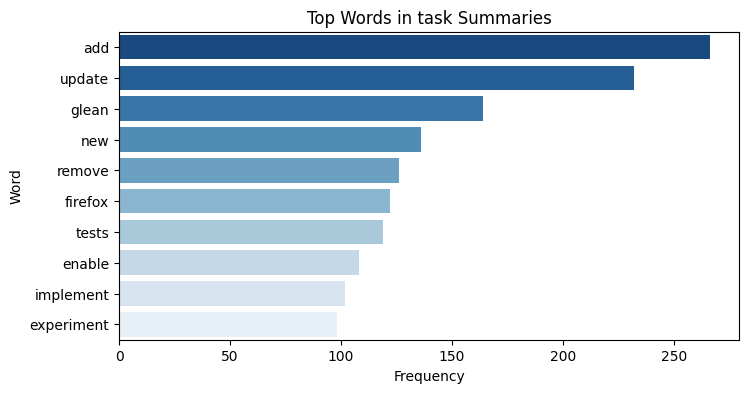

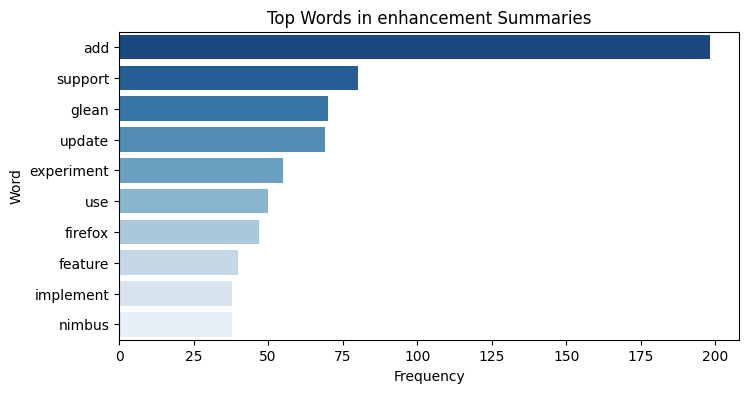


Correlation Matrix:
              Year  Month  Type_encoded
Year          1.00  -0.10          0.37
Month        -0.10   1.00         -0.01
Type_encoded  0.37  -0.01          1.00


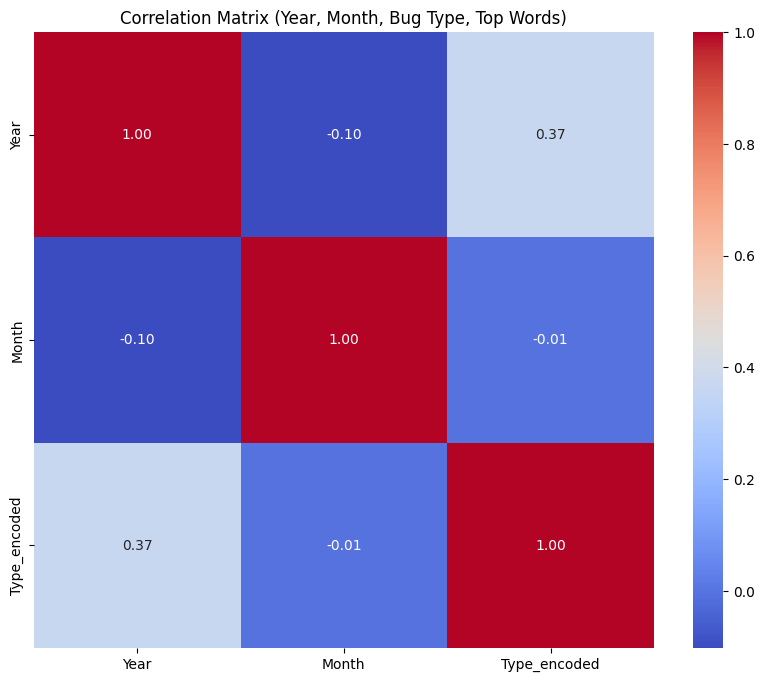


Strong correlations (>|0.3|):
Type_encoded  Year            0.366585
Year          Type_encoded    0.366585
dtype: float64

EXTENDED CORRELATION MATRIX SECTION (Label Encoded)

Correlation Matrix:
                          Year  Month  Type_encoded  Product_grouped_encoded  \
Year                     1.00  -0.10          0.37                     0.05   
Month                   -0.10   1.00         -0.01                     0.00   
Type_encoded             0.37  -0.01          1.00                     0.11   
Product_grouped_encoded  0.05   0.00          0.11                     1.00   
Component_encoded        0.01  -0.01          0.02                     0.20   

                         Component_encoded  
Year                                  0.01  
Month                                -0.01  
Type_encoded                          0.02  
Product_grouped_encoded               0.20  
Component_encoded                     1.00  


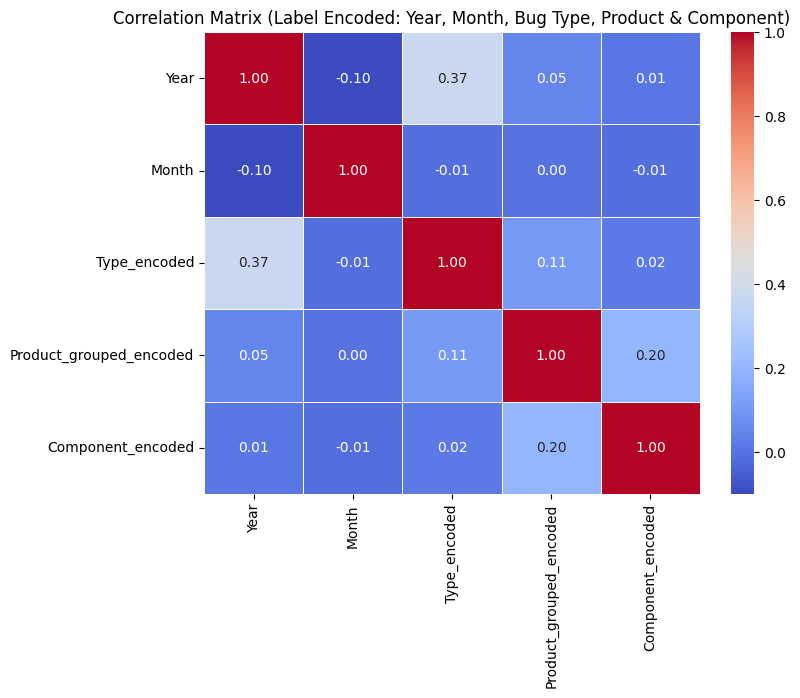


Correlation of Each Feature with Target (Bug Type):

Year                       0.37
Product_grouped_encoded    0.11
Component_encoded          0.02
Month                     -0.01
Name: Type_encoded, dtype: float64

Strongly correlated features with Bug Type (>|0.3|):
 Year    0.37
Name: Type_encoded, dtype: float64


C:\Users\USER\AppData\Local\Temp\ipykernel_2648\2853061669.py:229: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette="viridis")


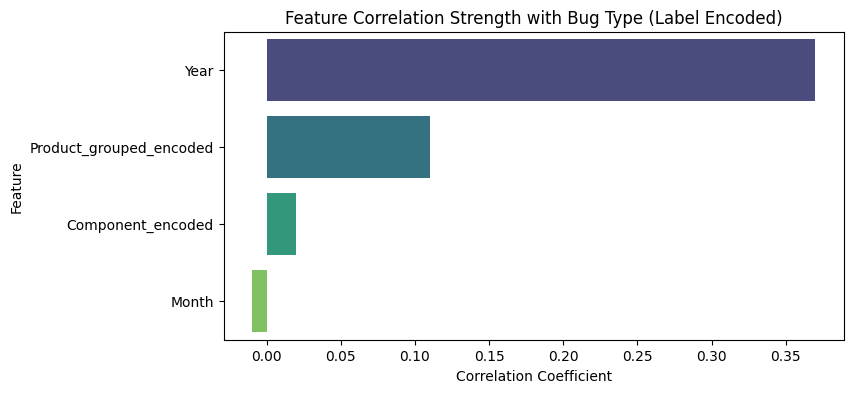

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv("C:/Users/USER/Downloads/bugs-2025-02-23.csv")
#first understand the data
print(df.shape)
print(df.info())
print(df.describe())

print(df.columns)
print(df.head())

#columns: status and resoulution are not useful for predicting bug type as these features(status and resolution) must come after predicting bug type
#bug id column is of no use but just a number shows the bug entry.

new_df1=df.drop(columns=["Bug ID","Status","Resolution","Assignee"])
new_df1

#now we will expand updated column by separating time, year, month, and day
#first change the dtypes of columns from object to string for type, summary, product and updated

new_df1["Type"]=new_df1["Type"].astype("category")
new_df1["Summary"]=new_df1["Summary"].astype("string")
new_df1["Product"]=new_df1["Product"].astype("category")
new_df1["Component"]=new_df1["Component"].astype("category")
new_df1["Updated"] = pd.to_datetime(new_df1["Updated"], errors="coerce")

#updated column is only useful if we extract year or month bcz that will show which bug type more common in that month of year.

new_df1["Year"]=new_df1["Updated"].dt.year
new_df1["Month"]=new_df1["Updated"].dt.month

#now i can drop updated column
new_df1=new_df1.drop(columns=["Updated"])

new_df1.isna().sum() #it shows me that there is no missing values in my dataset

#now check class balance
new_df1["Type"].value_counts()

#as type contains three unique values-> defect(6712), task(2280), enhancement(1008), so first balance the class using smote for which one hot encoding is needed
# Get top 15 products by frequency
top_products = new_df1["Product"].value_counts().nlargest(15).index
# Replace all other products with "Other"
new_df1["Product_grouped"] = new_df1["Product"].apply(lambda x: x if x in top_products else "Other")
print(new_df1["Product_grouped"].value_counts())
#so now drop product column
new_df1=new_df1.drop(columns=["Product"])

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
import pandas as pd

# Features & target
X = new_df1.drop("Type", axis=1)
y = new_df1["Type"]

# Define feature types
text_features = ["Summary"]
categorical_features = ["Product_grouped", "Component"]
numeric_features = ["Year", "Month"]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=500), "Summary"),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_processed, y)

print("Before SMOTE:\n", y.value_counts())
print("After SMOTE:\n", pd.Series(y_resampled).value_counts())

#will show how the class balancing effects visually
class_order=["defect","task","enhancement"]
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(x=y,order=class_order,color='Grey')
plt.title("Class Distribution Before SMOTE")

plt.subplot(1,2,2)
sns.countplot(x=y_resampled,order=class_order,color='Brown')
plt.title("Class Distribution After SMOTE")
plt.show()

#bugs per year
plt.figure(figsize=(8,5))
sns.countplot(x=new_df1["Year"],order=sorted(new_df1["Year"].unique()),color="Brown")
plt.title("Number of Bugs per Year")
plt.xticks(rotation=45)
plt.show()

#bug type distribution per product
plt.figure(figsize=(12,6))
sns.countplot(data=new_df1,x="Product_grouped",hue="Type", order=new_df1["Product_grouped"].value_counts().index)
plt.title("Bug Type Distribution Across Products")
plt.xticks(rotation=45)
plt.show()

#to show common words in bug use wordcloud
from wordcloud import WordCloud

text = " ".join(new_df1["Summary"].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Common Words in Bug Summaries")
plt.show()


# Pivot heatmap: products x year
pivot = new_df1.pivot_table(index="Product_grouped", columns="Year", values="Summary", aggfunc="count").fillna(0)
plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Bugs per Product per Year")
plt.show()

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words="english", max_features=20)
for bug_type in new_df1["Type"].unique():
    summaries = new_df1[new_df1["Type"]==bug_type]["Summary"].dropna().astype(str)
    counts = vectorizer.fit_transform(summaries)
    word_freq = dict(zip(vectorizer.get_feature_names_out(), counts.toarray().sum(axis=0)))
    top_words = pd.Series(word_freq).sort_values(ascending=False).head(10)

    plt.figure(figsize=(8,4))
    sns.barplot(x=top_words.values,
                y=top_words.index,
                hue=top_words.index,
                palette="Blues_r",
                dodge=False,
                legend=False)
    plt.title(f"Top Words in {bug_type} Summaries")
    plt.xlabel("Frequency")   #x-axis:how many times the word appeared
    plt.ylabel("Word")        #y-axis:the actual word
    plt.show()


# Since we have text and categorical data, we can only compute correlation
# on numeric features (Year, Month) or encoded forms.
# We'll create a DataFrame with Year, Month, and a numeric encoding of Type for visualization.

# Copy numeric subset
corr_df = new_df1[["Year", "Month"]].copy()

# Encode target (Type) as numeric for correlation
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
corr_df["Type_encoded"] = le.fit_transform(new_df1["Type"])

# Compute correlation
corr_matrix = corr_df.corr()

# Show correlation values
print("\nCorrelation Matrix:")
print(corr_matrix.round(2))

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Year, Month, Bug Type, Top Words)")
plt.show()

threshold = 0.3
strong_corr = corr_matrix.unstack().sort_values(ascending=False)
strong_corr = strong_corr[(abs(strong_corr) > threshold) & (strong_corr < 1)]

print("\nStrong correlations (>|0.3|):")
print(strong_corr)

# result shows that bug_type n year are somewhat related
from sklearn.preprocessing import LabelEncoder

print("\nEXTENDED CORRELATION MATRIX SECTION (Label Encoded)")

# Create a copy of the dataframe with relevant features
corr_df = new_df1[["Year", "Month", "Type", "Product_grouped", "Component"]].copy()

# Encode all categorical columns using LabelEncoder
le_type = LabelEncoder()
le_product = LabelEncoder()
le_component = LabelEncoder()

corr_df["Type_encoded"] = le_type.fit_transform(corr_df["Type"])
corr_df["Product_grouped_encoded"] = le_product.fit_transform(corr_df["Product_grouped"])
corr_df["Component_encoded"] = le_component.fit_transform(corr_df["Component"])

# Compute correlation matrix
corr_matrix = corr_df[["Year", "Month", "Type_encoded", "Product_grouped_encoded", "Component_encoded"]].corr().round(2)

# Print numeric correlation table
print("\nCorrelation Matrix:\n", corr_matrix)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Label Encoded: Year, Month, Bug Type, Product & Component)")
plt.show()

# TOP CORRELATIONS WITH TARGET
target_corr = corr_matrix["Type_encoded"].drop("Type_encoded").sort_values(ascending=False)
print("\nCorrelation of Each Feature with Target (Bug Type):\n")
print(target_corr)

# Highlight features with notable correlation (>|0.3|)
threshold = 0.3
strong_corr = target_corr[abs(target_corr) > threshold]

if not strong_corr.empty:
    print("\nStrongly correlated features with Bug Type (>|0.3|):\n", strong_corr)
else:
    print("\nNo features show strong correlation (>|0.3|). Relationships are weak or moderate.")

# Optional bar plot for feature correlation with Bug Type
plt.figure(figsize=(8,4))
sns.barplot(x=target_corr.values, y=target_corr.index, palette="viridis")
plt.title("Feature Correlation Strength with Bug Type (Label Encoded)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()


# Model Training


KNN Implementation

Scaling: Numeric columns Year and Month are scaled using StandardScaler to bring them to comparable ranges. This is important for distance-based algorithms like KNN.

Train-Test Split: Split the dataset into 80% training and 20% testing with stratify=y_resampled to maintain class balance in both sets.

Initial k: Calculated using sqrt(n_train) as a rule of thumb for KNN. This provides a reasonable starting point.

K Tuning: We test several odd values of k around the initial estimate to find the optimal k that gives the highest accuracy.

Weighted KNN: weights='distance' is used so closer neighbors contribute more to the prediction than farther ones, improving accuracy especially on imbalanced or noisy datasets.

Distance Metric: metric='cosine' is chosen because the feature space is high-dimensional (TF-IDF + one-hot features), and cosine distance works better for sparse vectors than Euclidean distance.

Parallelization: n_jobs=-1 uses all CPU cores to speed up computation on large datasets.

Evaluation: accuracy_score is used to measure performance on the test set. Each k is evaluated and printed.

Best k: The value of k with the highest accuracy is selected and printed as the optimal k.

"We scaled numeric features, split the data while maintaining class balance, and used a weighted KNN with cosine distance. Multiple k values were tested to find the optimal one for highest accuracy, leveraging distance weighting and parallel computation to improve performance on this high-dimensional, large dataset."

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_resampled = X_resampled.toarray() if not isinstance(X_resampled, np.ndarray) else X_resampled
#Scale numeric columns (Year, Month)
scaler = StandardScaler()
X_resampled[:, -2:] = scaler.fit_transform(X_resampled[:, -2:])

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

n_train = X_train.shape[0]
initial_k = int(np.sqrt(n_train))
print(f"Initial estimate for k based on sqrt(n_train): {initial_k}")

#Define k values to test
k_values = list(range(max(1, initial_k-10), initial_k+11, 2))
accuracies = []

for k in k_values:
    #Weighted KNN with cosine distance
    knn = KNeighborsClassifier(
        n_neighbors=k,
        weights='distance',
        metric='cosine',
        n_jobs=-1
    )
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"k={k} --> Accuracy: {acc*100:.4f}%")

best_k = k_values[np.argmax(accuracies)]
print(f"\nBest k: {best_k} with Accuracy: {max(accuracies)*100:.4f}%")

Initial estimate for k based on sqrt(n_train): 126
k=116 --> Accuracy: 81.6286%
k=118 --> Accuracy: 81.4548%
k=120 --> Accuracy: 81.3803%
k=122 --> Accuracy: 81.3307%
k=124 --> Accuracy: 81.3307%
k=126 --> Accuracy: 81.2314%
k=128 --> Accuracy: 81.3555%
k=130 --> Accuracy: 81.2810%
k=132 --> Accuracy: 81.2562%
k=134 --> Accuracy: 81.1569%
k=136 --> Accuracy: 81.1072%

Best k: 116 with Accuracy: 81.6286%


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Ensure data is in numpy array
X_resampled = X_resampled.toarray() if not isinstance(X_resampled, np.ndarray) else X_resampled

# Scale numeric columns (assuming last 2 are numeric)
scaler = StandardScaler()
X_resampled[:, -2:] = scaler.fit_transform(X_resampled[:, -2:])

#Split into train, validation, and test sets
#First split: train_temp (80%) + test (20%)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

#Second split: train (70%) + validation (10%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, test_size=0.125, random_state=42, stratify=y_train_temp
)
# (0.8 * 0.125 = 0.1 of total data → 70/10/20 split)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

#Find best k using validation set
n_train = X_train.shape[0]
initial_k = int(np.sqrt(n_train))
print(f"\nInitial estimate for k based on sqrt(n_train): {initial_k}")

k_values = list(range(max(1, initial_k - 10), initial_k + 11, 2))
val_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(
        n_neighbors=k,
        weights='distance',
        metric='cosine',
        n_jobs=-1
    )
    knn.fit(X_train, y_train)
    y_val_pred = knn.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(acc)
    print(f"k={k} --> Validation Accuracy: {acc*100:.4f}%")

best_k = k_values[np.argmax(val_accuracies)]
print(f"\nBest k (on validation): {best_k} with Accuracy: {max(val_accuracies)*100:.4f}%")

#Final Evaluation on Test Set
knn_best = KNeighborsClassifier(
    n_neighbors=best_k,
    weights='distance',
    metric='cosine',
    n_jobs=-1
)
knn_best.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
y_test_pred = knn_best.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"\nFinal Test Accuracy (using best k={best_k}): {test_acc*100:.4f}%")

print("SECOND VALIDATION SPLITTING\n")

#second splitting
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, test_size=0.1875, random_state=42, stratify=y_train_temp
)
# (0.8 * 0.1875 = 0.2 of total data → 60/20/20 split)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

#Find best k using validation set
n_train = X_train.shape[0]
initial_k = int(np.sqrt(n_train))
print(f"\nInitial estimate for k based on sqrt(n_train): {initial_k}")

k_values = list(range(max(1, initial_k - 10), initial_k + 11, 2))
val_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(
        n_neighbors=k,
        weights='distance',
        metric='cosine',
        n_jobs=-1
    )
    knn.fit(X_train, y_train)
    y_val_pred = knn.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(acc)
    print(f"k={k} --> Validation Accuracy: {acc*100:.4f}%")

best_k = k_values[np.argmax(val_accuracies)]
print(f"\nBest k (on validation): {best_k} with Accuracy: {max(val_accuracies)*100:.4f}%")

#Final Evaluation on Test Set
knn_best = KNeighborsClassifier(
    n_neighbors=best_k,
    weights='distance',
    metric='cosine',
    n_jobs=-1
)
knn_best.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
y_test_pred = knn_best.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"\nFinal Test Accuracy (using best k={best_k}): {test_acc*100:.4f}%")

#THIRD SPLITTING :30 PERCENY

print("THIRD VALIDATION SPLITTING\n ")
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, test_size=0.375, random_state=42, stratify=y_train_temp
)
# (0.8 * 0.375 = 0.1 of total data → 50/30/20 split)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

#Find best k using validation set
n_train = X_train.shape[0]
initial_k = int(np.sqrt(n_train))
print(f"\nInitial estimate for k based on sqrt(n_train): {initial_k}")

k_values = list(range(max(1, initial_k - 10), initial_k + 11, 2))
val_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(
        n_neighbors=k,
        weights='distance',
        metric='cosine',
        n_jobs=-1
    )
    knn.fit(X_train, y_train)
    y_val_pred = knn.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(acc)
    print(f"k={k} --> Validation Accuracy: {acc*100:.4f}%")

best_k = k_values[np.argmax(val_accuracies)]
print(f"\nBest k (on validation): {best_k} with Accuracy: {max(val_accuracies)*100:.4f}%")

#Final Evaluation on Test Set
knn_best = KNeighborsClassifier(
    n_neighbors=best_k,
    weights='distance',
    metric='cosine',
    n_jobs=-1
)
knn_best.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
y_test_pred = knn_best.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"\nFinal Test Accuracy (using best k={best_k}): {test_acc*100:.4f}%")



Train: 14094, Validation: 2014, Test: 4028

Initial estimate for k based on sqrt(n_train): 118
k=108 --> Validation Accuracy: 78.5998%
k=110 --> Validation Accuracy: 78.5501%
k=112 --> Validation Accuracy: 78.5005%
k=114 --> Validation Accuracy: 78.3515%
k=116 --> Validation Accuracy: 78.3515%
k=118 --> Validation Accuracy: 78.2026%
k=120 --> Validation Accuracy: 78.2026%
k=122 --> Validation Accuracy: 78.2026%
k=124 --> Validation Accuracy: 78.1529%
k=126 --> Validation Accuracy: 78.1033%
k=128 --> Validation Accuracy: 78.0536%

Best k (on validation): 108 with Accuracy: 78.5998%

Final Test Accuracy (using best k=108): 81.7527%
SECOND VALIDATION SPLITTING

Train: 13087, Validation: 3021, Test: 4028

Initial estimate for k based on sqrt(n_train): 114
k=104 --> Validation Accuracy: 78.7819%
k=106 --> Validation Accuracy: 78.4508%
k=108 --> Validation Accuracy: 78.3184%
k=110 --> Validation Accuracy: 78.1860%
k=112 --> Validation Accuracy: 78.2522%
k=114 --> Validation Accuracy: 78.1198

Train: 14094, Validation: 2014, Test: 4028

Initial estimate for k based on sqrt(n_train): 118
k=108 --> Validation Accuracy: 78.5998%
k=110 --> Validation Accuracy: 78.5501%
k=112 --> Validation Accuracy: 78.5005%
k=114 --> Validation Accuracy: 78.3515%
k=116 --> Validation Accuracy: 78.3515%
k=118 --> Validation Accuracy: 78.2026%
k=120 --> Validation Accuracy: 78.2026%
k=122 --> Validation Accuracy: 78.2026%
k=124 --> Validation Accuracy: 78.1529%
k=126 --> Validation Accuracy: 78.1033%
k=128 --> Validation Accuracy: 78.0536%

Best k (on validation): 108 with Accuracy: 78.5998%

Final Test Accuracy (using best k=108): 81.7527%
SECOND VALIDATION SPLITTING

Train: 13087, Validation: 3021, Test: 4028

Initial estimate for k based on sqrt(n_train): 114
k=104 --> Validation Accuracy: 78.7819%
k=106 --> Validation Accuracy: 78.4508%
k=108 --> Validation Accuracy: 78.3184%
k=110 --> Validation Accuracy: 78.1860%
k=112 --> Validation Accuracy: 78.2522%
k=114 --> Validation Accuracy: 78.1198%
k=116 --> Validation Accuracy: 78.2853%
k=118 --> Validation Accuracy: 78.0867%
k=120 --> Validation Accuracy: 78.1529%
k=122 --> Validation Accuracy: 77.9874%
k=124 --> Validation Accuracy: 77.9543%

Best k (on validation): 104 with Accuracy: 78.7819%

Final Test Accuracy (using best k=104): 82.0506%
THIRD VALIDATION SPLITTING

Train: 10067, Validation: 6041, Test: 4028

Initial estimate for k based on sqrt(n_train): 100
k=90 --> Validation Accuracy: 78.3811%
k=92 --> Validation Accuracy: 78.2652%
k=94 --> Validation Accuracy: 78.1328%
k=96 --> Validation Accuracy: 78.0997%
k=98 --> Validation Accuracy: 77.9672%
k=100 --> Validation Accuracy: 77.9010%
k=102 --> Validation Accuracy: 77.7189%
k=104 --> Validation Accuracy: 77.7851%
k=106 --> Validation Accuracy: 77.7686%
k=108 --> Validation Accuracy: 77.8679%
k=110 --> Validation Accuracy: 77.6030%

Best k (on validation): 90 with Accuracy: 78.3811%

Final Test Accuracy (using best k=90): 82.6713%


This cell trains and evaluates several common machine learning classification algorithms, including Decision Tree, Random Forest, Gaussian Naive Bayes, Logistic Regression, Gradient Boosting, and Support Vector Machine (SVM). For each classifier, it calculates and prints the accuracy, and visualizes the confusion matrix to understand its performance across different bug types.

Decision Tree Classifier Accuracy: 83.81%


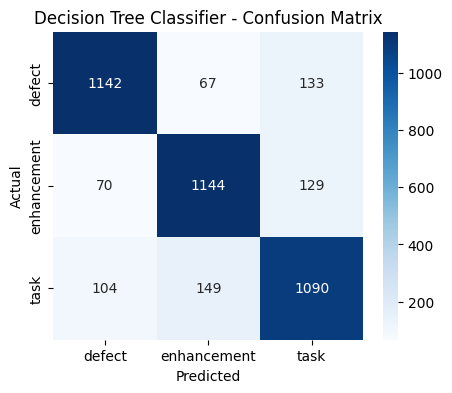

Random Forest Classifier Accuracy: 91.73%


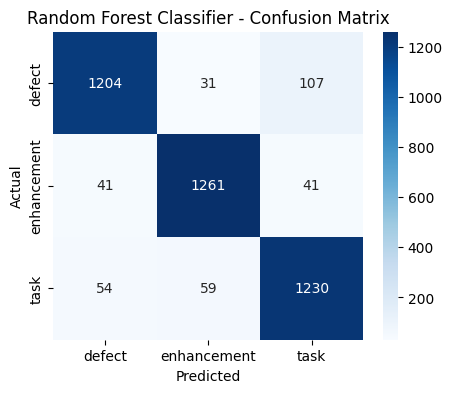

Gaussian Naive Bayes Accuracy: 62.51%


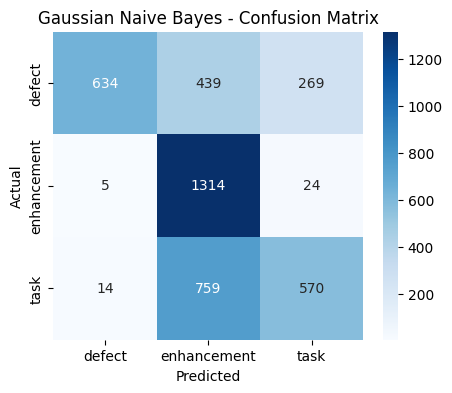

Logistic Regression Accuracy: 80.98%


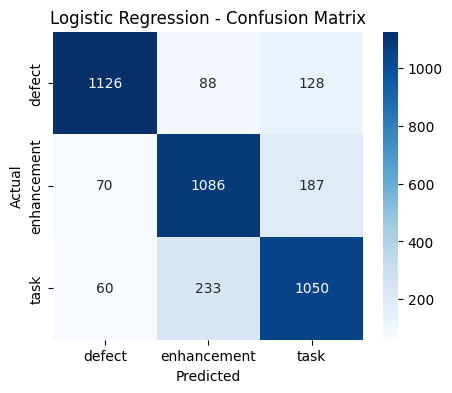

Gradient Boosting Accuracy: 78.40%


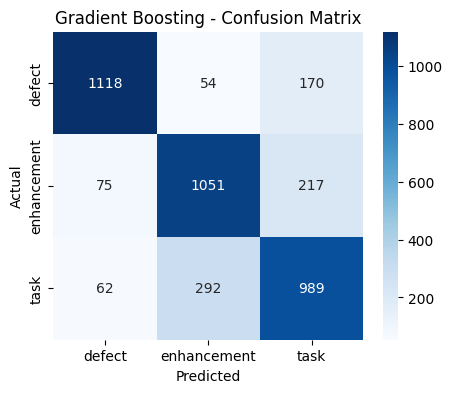

In [ ]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

classifiers = {
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=42),
    "Random Forest Classifier": RandomForestClassifier(random_state=42, n_jobs=-1),
    "Gaussian Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=500, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM (Linear Kernel)": SVC(kernel='linear', probability=True, random_state=42)
}

results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc*100:.2f}%")
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=le_type.classes_)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=le_type.classes_, yticklabels=le_type.classes_, cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

ensemble = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42)),
        ('lr', LogisticRegression(max_iter=500)),
        ('svm', SVC(kernel='linear', probability=True, random_state=42))  # <-- Added SVM
    ],
    voting='soft',
    n_jobs=-1
)

ensemble.fit(X_train, y_train)
y_pred_ens = ensemble.predict(X_test)
acc_ens = accuracy_score(y_test, y_pred_ens)
print("Ensemble Voting Classifier Accuracy:", acc_ens*100)

This cell visualizes the accuracy scores of the different machine learning models trained in the previous step. A bar plot is generated to provide a quick comparison of how each model performed in terms of classification accuracy.

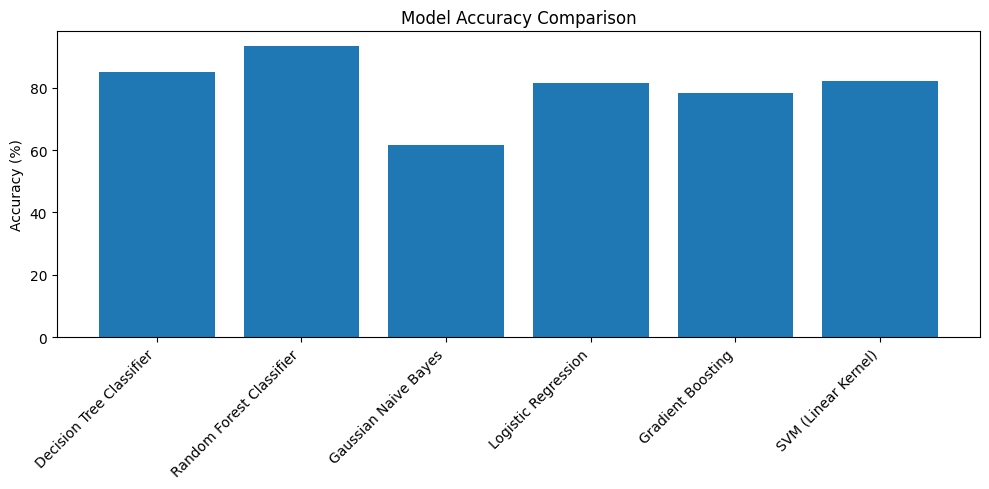

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

model_names = list(results.keys())
accuracies = [v * 100 for v in results.values()]

plt.figure(figsize=(10,5))
plt.bar(model_names, accuracies)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.tight_layout()
plt.show()

This cell organizes the model accuracy results into a pandas DataFrame and then exports these results to a CSV file named 'model_accuracy_results.csv'. This allows for easy storage and sharing of the model performance metrics.

In [ ]:
import pandas as pd

# Convert results dict → DataFrame
results_df = pd.DataFrame({
    "Model": list(results.keys()),
    "Accuracy (%)": [round(v * 100, 2) for v in results.values()]
})

# Save to CSV
results_df.to_csv("model_accuracy_results.csv", index=False)
print("Results exported to: model_accuracy_results.csv")

Results exported to: model_accuracy_results.csv


This code block implements a Stacking Classifier, which is an advanced ensemble method. It combines predictions from several base learners (Random Forest, Gradient Boosting, Logistic Regression, SVM) and uses a meta-learner (Logistic Regression) to make the final prediction. It calculates and displays the stacking classifier's accuracy and its confusion matrix.

Stacking Classifier Accuracy: 94.34%


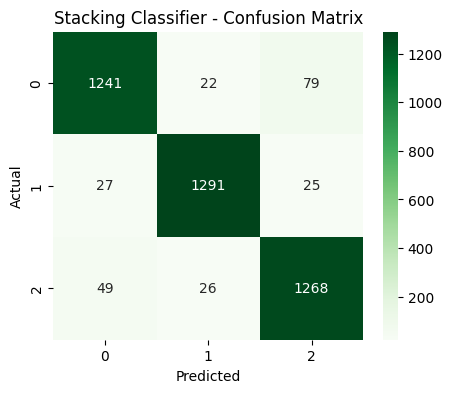


Meta Dataset Shape: (14094, 4)
Example Meta Features (Base Model Predictions):
[['enhancement' 'enhancement' 'enhancement' 'enhancement']
 ['enhancement' 'defect' 'task' 'task']
 ['task' 'task' 'task' 'task']
 ['task' 'enhancement' 'enhancement' 'enhancement']
 ['task' 'task' 'task' 'task']
 ['enhancement' 'enhancement' 'task' 'task']
 ['defect' 'defect' 'defect' 'defect']
 ['defect' 'defect' 'defect' 'defect']
 ['enhancement' 'enhancement' 'enhancement' 'enhancement']
 ['task' 'enhancement' 'enhancement' 'enhancement']]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    GradientBoostingClassifier, VotingClassifier, StackingClassifier
)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Base learners (Level-0 models)
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('lr', LogisticRegression(max_iter=500, random_state=42)),
    ('svm', SVC(kernel='linear', probability=True, random_state=42))
]

# Meta-learner (Level-1 model)
meta_learner = LogisticRegression(max_iter=500, random_state=42)

# Stacking Classifier
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    passthrough=True,   # Passes original features + base model predictions to meta learner
    n_jobs=-1
)

# Fit stacking model
stack_model.fit(X_train, y_train)

# Evaluate on test data
y_pred_stack = stack_model.predict(X_test)
acc_stack = accuracy_score(y_test, y_pred_stack)
print(f"Stacking Classifier Accuracy: {acc_stack*100:.2f}%")

# Confusion matrix visualization
cm_stack = confusion_matrix(y_test, y_pred_stack)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_stack, annot=True, fmt="d", cmap="Greens")
plt.title("Stacking Classifier - Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Create Meta Dataset (Base Model Predictions)
# Fit base learners individually to create meta features
fitted_base_learners = [(name, model.fit(X_train, y_train)) for name, model in base_learners]

# Stack their predictions on training data
meta_X = np.column_stack([
    model.predict(X_train) for _, model in fitted_base_learners
])
meta_y = y_train

print("\nMeta Dataset Shape:", meta_X.shape)
print("Example Meta Features (Base Model Predictions):")
print(meta_X[:10])